In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e8/sample_submission.csv
/kaggle/input/playground-series-s5e8/train.csv
/kaggle/input/playground-series-s5e8/test.csv


# Сиды

In [2]:
import os
import random
import numpy as np
import torch
import numpy as np # linear algebra
import pandas as pd 
try:
    # Hugging Face convenience fn; sets Python/Rand, NumPy, Torch seeds
    from transformers import set_seed  
except ImportError:
    set_seed = None

def seed_everything(seed):
    # 1. Python built‑ins
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)

    # 2. NumPy
    np.random.seed(seed)

    # 3. PyTorch (CPU & GPU)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # 4. CuDNN: make deterministic, but may slow you down
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # 5. Transformers (if installed)
    if set_seed is not None:
        set_seed(seed)

# call it!
seed_everything(42)

2025-08-16 22:55:41.071141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755384941.244236      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755384941.292085      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Импорты

In [3]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold, train_test_split 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Загрузка данных

In [4]:
train=pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv')
sample=pd.read_csv('/kaggle/input/playground-series-s5e8/sample_submission.csv')


# EDA

# Хорошие идеи для EDA


In [5]:
train

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,29,services,single,secondary,no,1282,no,yes,unknown,4,jul,1006,2,-1,0,unknown,1
749996,749996,69,retired,divorced,tertiary,no,631,no,no,cellular,19,aug,87,1,-1,0,unknown,0
749997,749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,17,apr,113,1,-1,0,unknown,0
749998,749998,32,technician,married,secondary,no,-274,no,no,cellular,26,aug,108,6,-1,0,unknown,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


In [7]:
num_feats=train.drop(columns=['id']).select_dtypes(include='number').columns.tolist()
cat_feats=train.select_dtypes(include='object').columns.tolist()

In [8]:
num_feats

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']

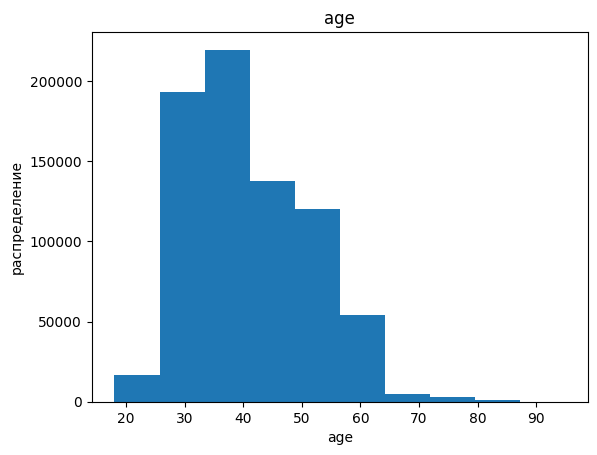

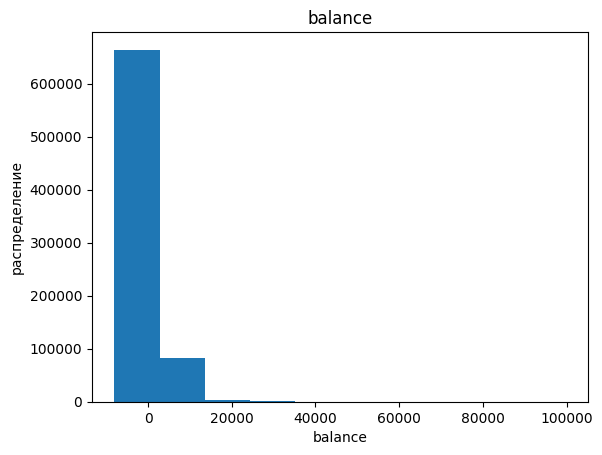

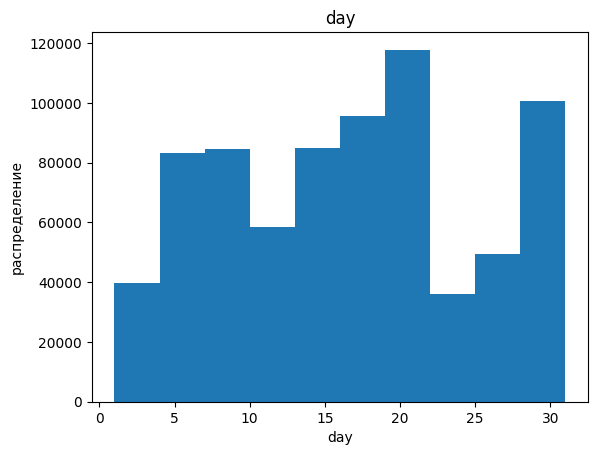

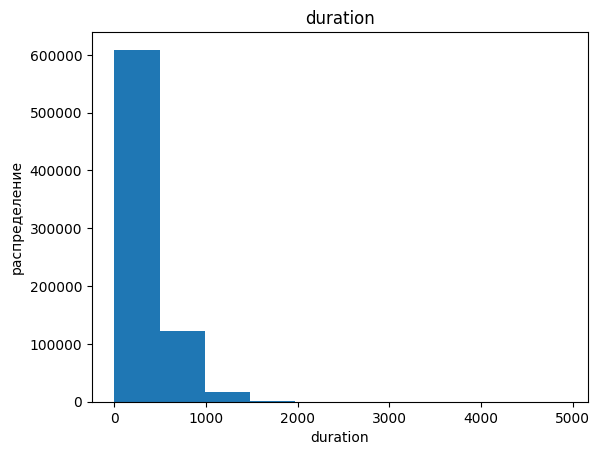

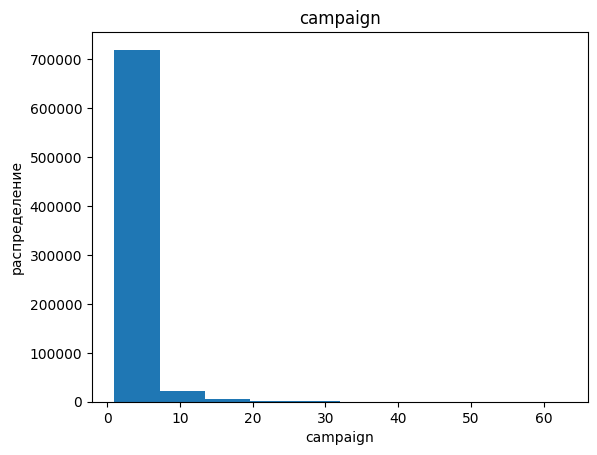

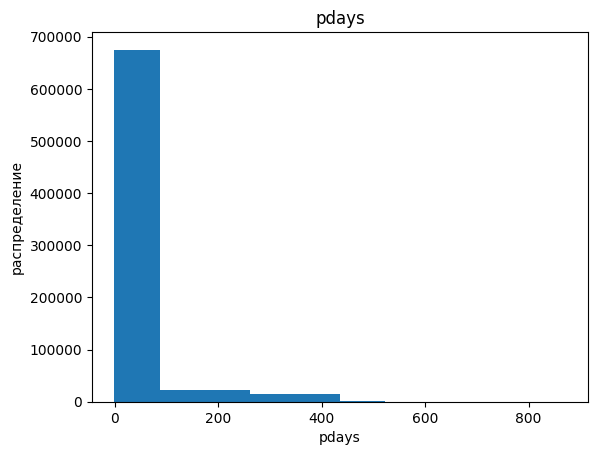

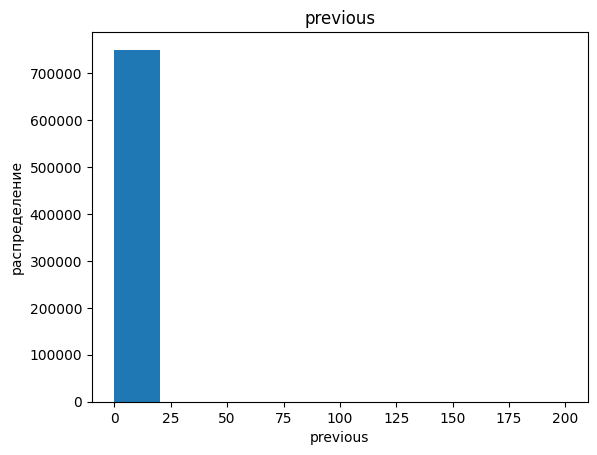

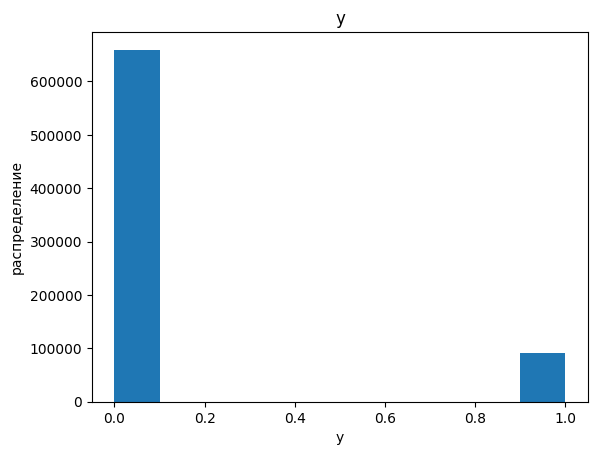

In [9]:
for col in num_feats:
    plt.figure()
    plt.hist(train[col])
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('распределение')
    plt.plot()
    
    
    

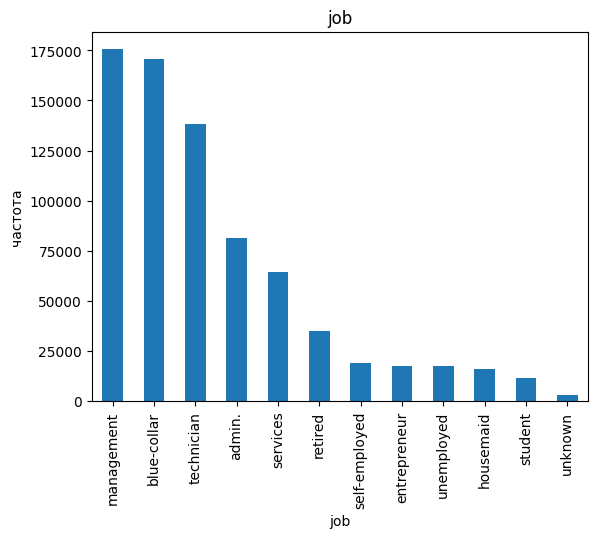

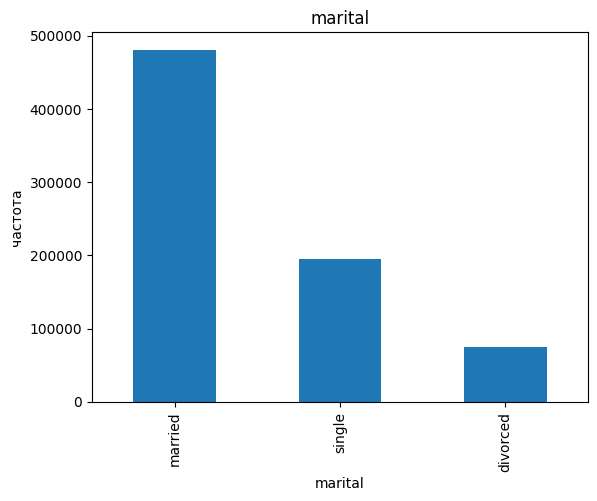

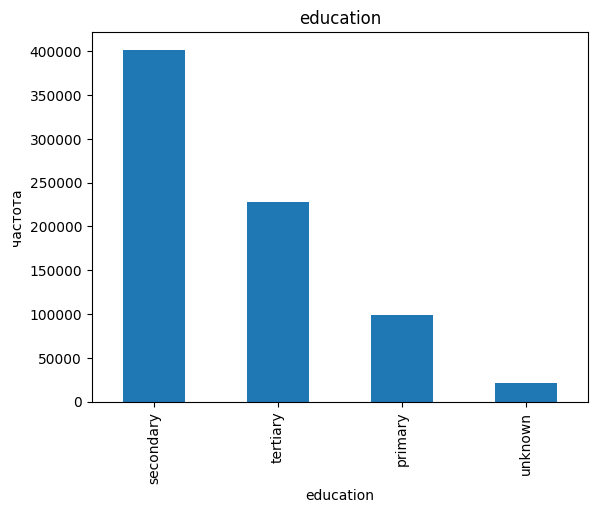

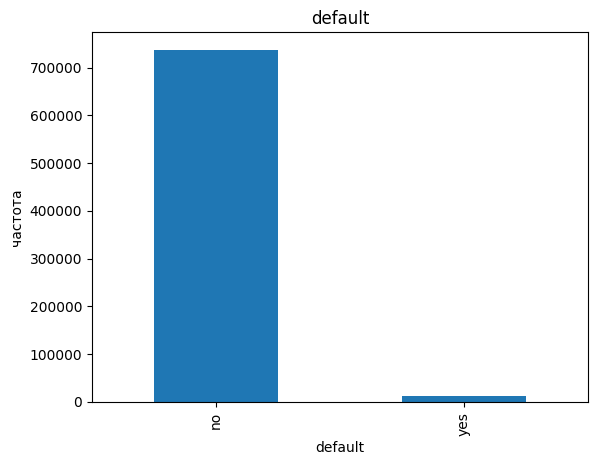

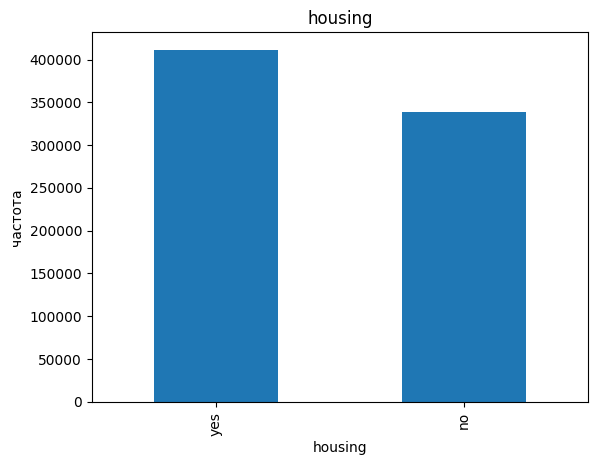

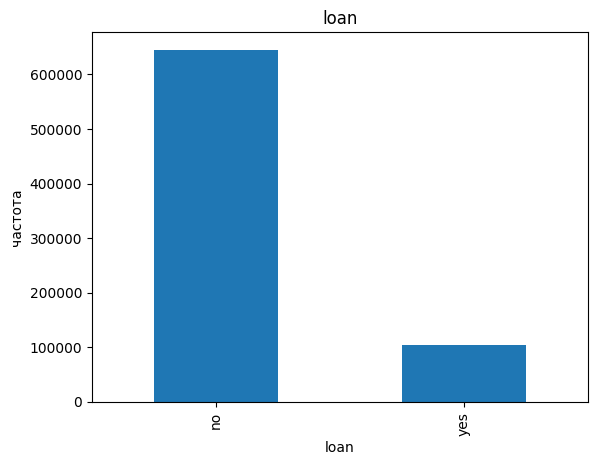

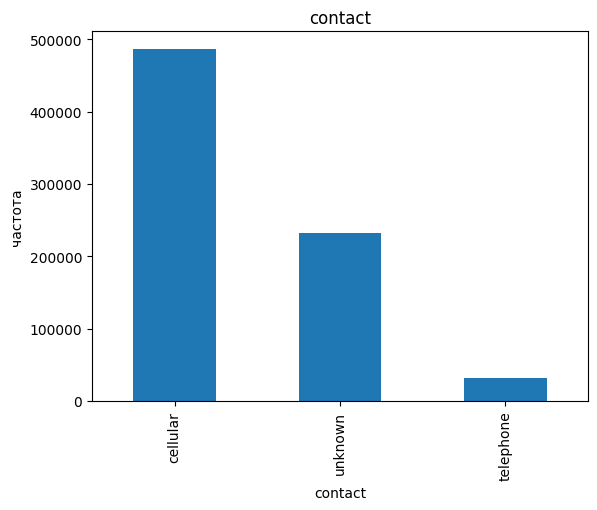

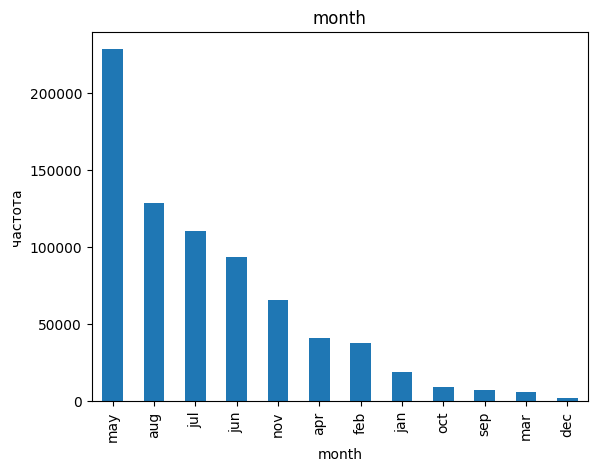

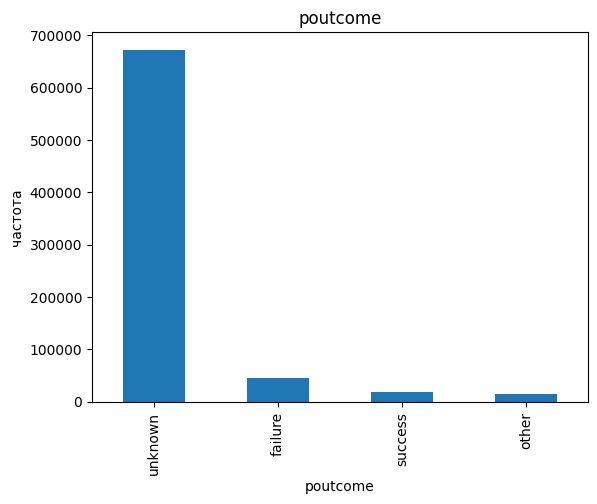

In [10]:
for col in cat_feats:
    counts=train[col].value_counts()
    plt.figure()
    counts.plot(kind='bar')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('частота')
    

    
    plt.plot()

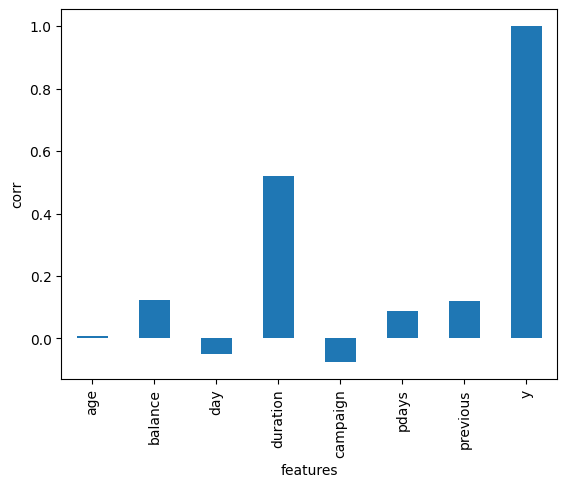

In [11]:
cor_with_y=train[num_feats].corrwith(train['y'])
plt.figure()
cor_with_y.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('corr')
plt.show()

In [12]:
'''
надо по двух классам посмотреть 
потом корреляцию для категориальных
потом как я люблю полиномиальные всякие и глянуть на самые лучшие
'''

'\nнадо по двух классам посмотреть \nпотом корреляцию для категориальных\nпотом как я люблю полиномиальные всякие и глянуть на самые лучшие\n'

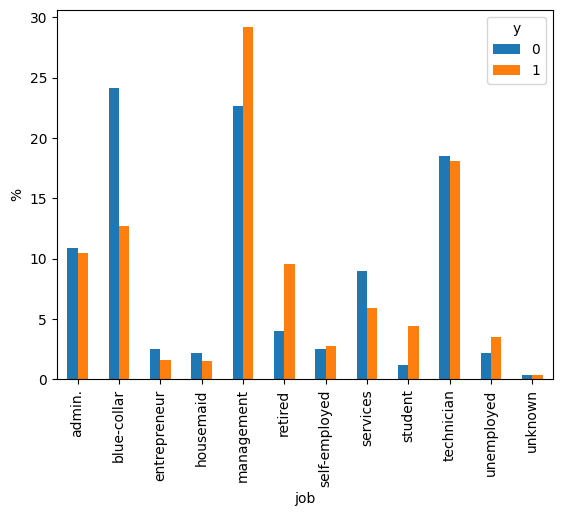

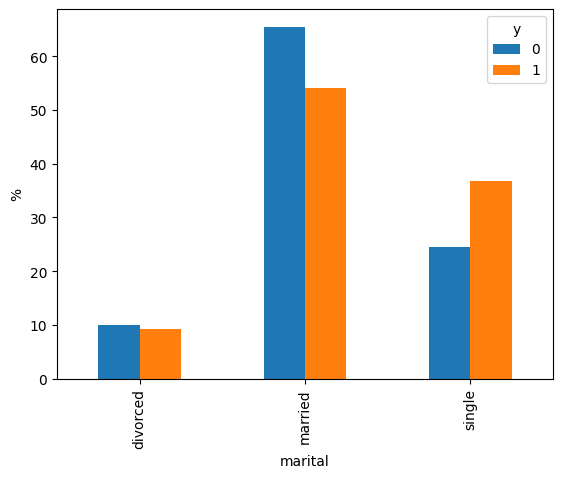

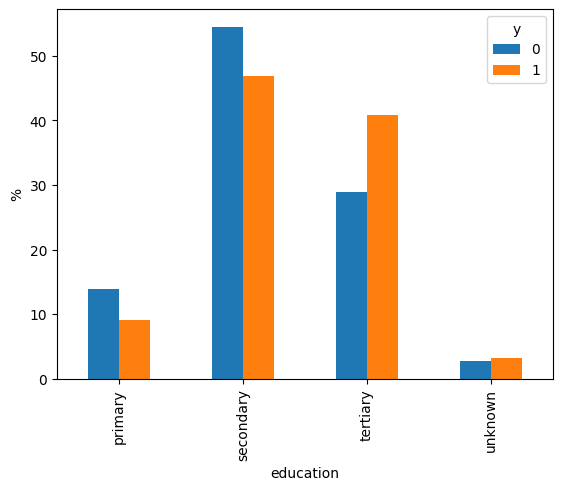

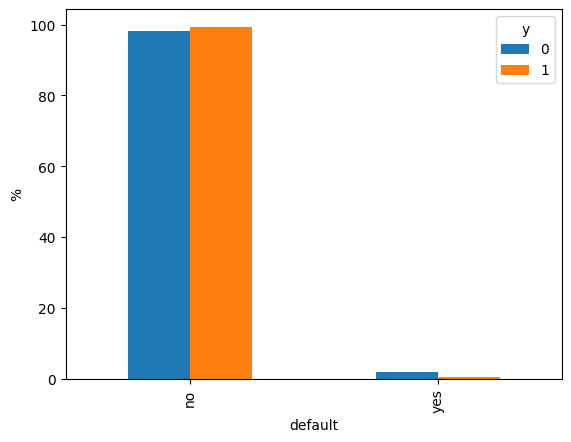

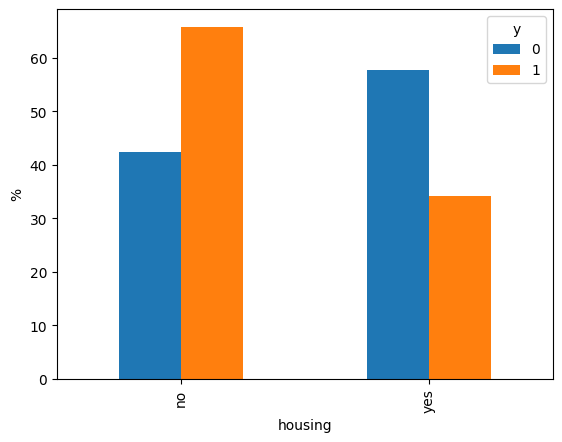

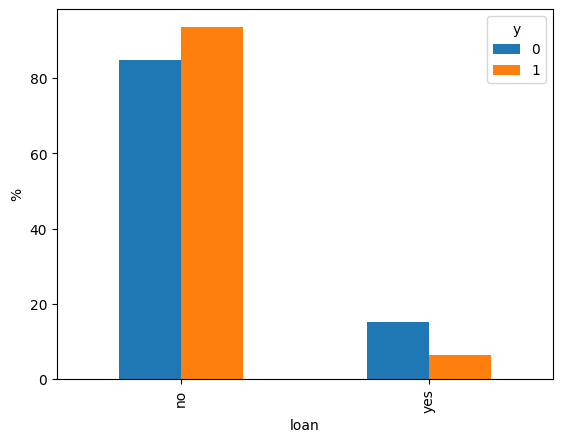

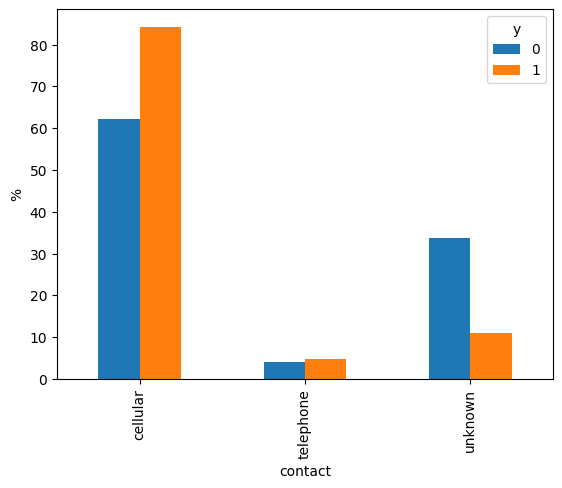

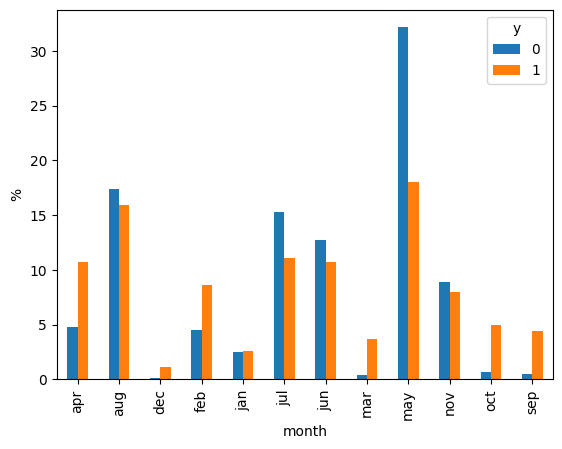

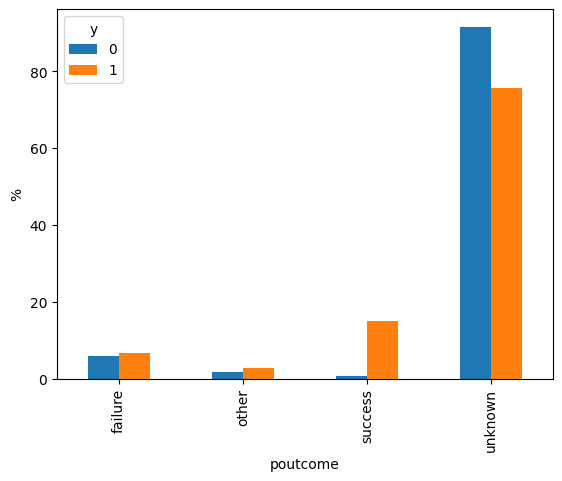

In [13]:
for col in cat_feats:
    cat_crt=pd.crosstab(train[col], train['y'], normalize='columns')*100
    ax=cat_crt.plot(kind='bar')
    ax.set_xlabel(col)
    ax.set_ylabel('%')
    plt.show()
    

In [14]:
#for col in num_feats:
    

# Feature engineering

In [15]:
'''
duration 
balance
previous 
pdays
day

month
contact
education 
martcial 
poutcome
housing
job




Идеи фичей:
new_feat1=duration-balance/duration +previous 
new_feat2=duration/pdays (плюс маленькое число)
new_feat3=balance/duration
new_feat10=previous / pdays(плюс маленькое число)
new_feat12=duration/day
new_feat13=day/month(типо из 12)
new_feat14=balance/day
new_feat15=day/pdays
new_feat16=pdays-duration
new_feat17=previous-balance
new_feat18=balance+previous 


new_feat4=martcial+job
new_feat5=poutcome+month 
new_feat6=housing+education
new_feat7=job+education+martial
new_feat8=poutcome+housing
new_feat9=month+martcial
new_feat11=month+education


marital
'''

'\nduration \nbalance\nprevious \npdays\nday\n\nmonth\ncontact\neducation \nmartcial \npoutcome\nhousing\njob\n\n\n\n\nИдеи фичей:\nnew_feat1=duration-balance/duration +previous \nnew_feat2=duration/pdays (плюс маленькое число)\nnew_feat3=balance/duration\nnew_feat10=previous / pdays(плюс маленькое число)\nnew_feat12=duration/day\nnew_feat13=day/month(типо из 12)\nnew_feat14=balance/day\nnew_feat15=day/pdays\nnew_feat16=pdays-duration\nnew_feat17=previous-balance\nnew_feat18=balance+previous \n\n\nnew_feat4=martcial+job\nnew_feat5=poutcome+month \nnew_feat6=housing+education\nnew_feat7=job+education+martial\nnew_feat8=poutcome+housing\nnew_feat9=month+martcial\nnew_feat11=month+education\n\n\nmarital\n'

In [16]:
def featurize(df):
    #df['new_feat1']=df['duration']-df['balance']/df['duration']+df['previous']
    
    df['new_feat2']=df['duration']/(df['pdays']) 
    df['new_feat3']=df['balance']/df['duration']
    df['new_feat10']=df['previous'] / (df['pdays'])
    df['new_feat12']=df['duration']/df['day']
    #df['new_feat13']=df['day']/df['month'](типо из 12)
    df['new_feat14']=df['balance']/df['day']
    df['new_feat15']=df['day']/df['pdays']
    df['new_feat16']=df['pdays']-df['duration']
    df['new_feat17']=df['previous']-df['balance']
    df['new_feat18']=df['balance']+df['previous'] 
    
    
    df['new_feat4']=df['marital']+'_'+df['job']
    df['new_feat5']=df['poutcome']+'_'+df['month']
    df['new_feat6']=df['housing']+'_'+df['education']
    df['new_feat7']=df['job']+'_'+df['education']+'_'+df['marital']
    df['new_feat8']=df['poutcome']+'_'+df['housing']
    df['new_feat9']=df['month']+'_'+df['marital']
    df['new_feat11']=df['month']+'_'+df['education']
    df['new_feat19']=df['housing']+df['poutcome']+df['job']
    binary_map = {'yes': 1, 'no': 0}
    df['default'] = df['default'].map(binary_map)
    df['housing'] = df['housing'].map(binary_map)
    df['loan'] = df['loan'].map(binary_map)
    df['log_balance']  = np.log1p(df['balance'] - df['balance'].min() + 1)
    df['log_duration'] = np.log1p(df['duration'])
    
    return df

In [17]:
train=featurize(train)

In [18]:
num_feats=train.select_dtypes(include='number').columns.tolist()

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


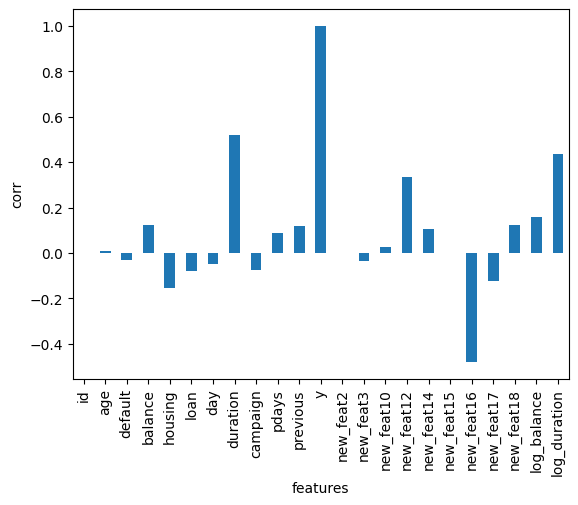

In [19]:
cor_with_y=train[num_feats].corrwith(train['y'])
plt.figure()
cor_with_y.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('corr')
plt.show()

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# --- 1) Cramér’s V для категориальный↔категориальный (с коррекцией) ---
def cramers_v_corrected(x: pd.Series, y: pd.Series) -> float:
    a = x.astype("category")
    b = y.astype("category")
    tbl = pd.crosstab(a, b)
    if tbl.shape[0] < 2 or tbl.shape[1] < 2:
        return 0.0
    chi2, _, _, _ = chi2_contingency(tbl, correction=False)
    n = tbl.values.sum()
    if n == 0:
        return 0.0
    phi2 = chi2 / n
    r, k = tbl.shape
    # смещение
    phi2_corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    k_corr = k - ((k - 1) ** 2) / (n - 1)
    denom = min(r_corr - 1, k_corr - 1)
    if denom <= 0:
        return 0.0
    return float(np.sqrt(phi2_corr / denom))

# --- 2) Корреляционное отношение η для категориальный↔числовой ---
def correlation_ratio(categories: pd.Series, values: pd.Series) -> float:
    """
    η = sqrt(SS_between / SS_total)
    categories — категориальный признак
    values — числовой таргет (регрессия)
    """
    cats = categories.astype("category")
    vals = pd.to_numeric(values, errors="coerce")
    mask = cats.notna() & vals.notna()
    cats = cats[mask]
    vals = vals[mask]
    if len(vals) == 0 or cats.nunique() < 2:
        return 0.0

    overall_mean = vals.mean()
    ss_total = ((vals - overall_mean) ** 2).sum()
    if ss_total == 0:
        return 0.0

    ss_between = 0.0
    for cat in cats.cat.categories:
        g = vals[cats == cat]
        if len(g) > 0:
            ss_between += len(g) * (g.mean() - overall_mean) ** 2
    eta = float(np.sqrt(ss_between / ss_total))
    return eta

# --- 3) Обёртка: связь cat-фич с таргетом (авто выбор метрики) ---
def cat_vs_target_corr(df: pd.DataFrame, cat_cols: list[str], target: str,
                       task: str | None = None) -> pd.Series:
    """
    task: 'clf' (классификация), 'reg' (регрессия) или None -> авто:
      - если у таргета <= 10 уникальных значений, считаем классификацией
    Возвращает pd.Series (score на [0,1]), отсортированную по убыванию.
    """
    y = df[target]
    if task is None:
        task = "clf" if (y.dtype.name in ["category", "bool"] or y.nunique(dropna=True) <= 10) else "reg"

    scores = {}
    if task == "clf":
        y_cat = y.astype("category")
        for c in cat_cols:
            scores[c] = cramers_v_corrected(df[c], y_cat)
    else:  # 'reg'
        for c in cat_cols:
            scores[c] = correlation_ratio(df[c], y)
    return pd.Series(scores).sort_values(ascending=False)

# --- 4) Быстрый барчарт важности связи ---
def plot_cat_vs_target(scores: pd.Series, top: int | None = 30, title: str = "Категориальные фичи vs таргет"):
    s = scores.dropna()
    if top is not None:
        s = s.head(top)
    fig_h = max(4, 0.35 * len(s))
    plt.figure(figsize=(8, fig_h))
    plt.barh(range(len(s)), s.values)
    plt.yticks(range(len(s)), s.index)
    plt.gca().invert_yaxis()
    plt.xlabel("Связь (0..1)")
    plt.title(title)
    for i, v in enumerate(s.values):
        plt.text(v, i, f"{v:.2f}", va="center", ha="left")
    plt.tight_layout()
    plt.show()

# ==== пример использования ====
# cat_cols = train.select_dtypes(include=["object","category"]).columns.tolist()
# scores = cat_vs_target_corr(df, cat_cols, target="y")      # авто определит тип задачи
# plot_cat_vs_target(scores, top=25)                         # барчарт топ-25
# print(scores)                                              # посмотреть значения


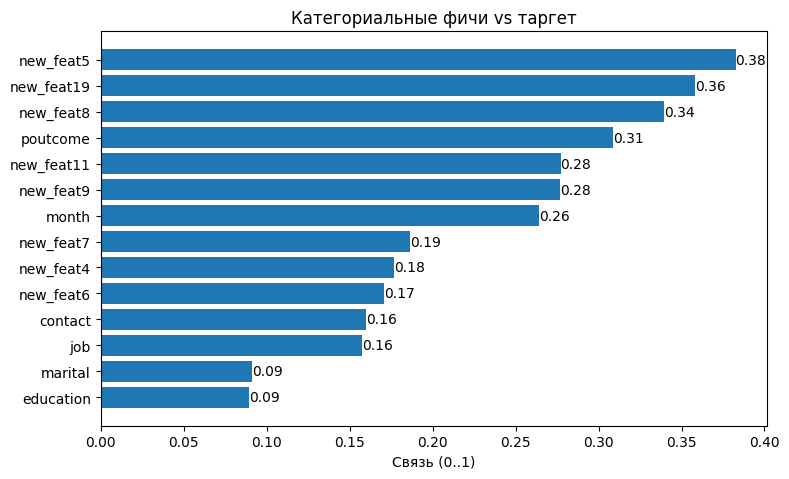

In [21]:
cat_cols = train.select_dtypes(include=["object","category"]).columns.tolist()
scores = cat_vs_target_corr(train, cat_cols, target="y")      # авто определит тип задачи
plot_cat_vs_target(scores, top=25)                         # барчарт топ-25
# print(scores)    

In [22]:
test=featurize(test)

# catboost

In [23]:
drop=['default', 'id', 'loan',  'balance']

In [24]:
train=train.drop(columns=drop)

In [25]:
id_test=test['id']

In [26]:
test=test.drop(columns=drop)

In [27]:
cat_feats=train.select_dtypes(include='object').columns.tolist()

In [28]:
X=train.drop(columns='y')
y=train['y']

надо разные гипы для катбустов(может быть)

In [29]:
oof=np.zeros(len(y))
catboost_feature_importances = []
test_pred=np.zeros(len(test))
test_pool = Pool(test, cat_features=cat_feats)
skf=StratifiedKFold(n_splits=3, shuffle=True)
for fold, (tr_idx, val_idx) in enumerate(skf.split(X,y),1):
    X_train, y_train=X.iloc[tr_idx], y.iloc[tr_idx]
    X_eval, y_eval=X.iloc[val_idx], y.iloc[val_idx]
    train_pool=Pool(
    X_train,
    label=y_train,
    cat_features=cat_feats,
    )
    eval_pool=Pool(
    X_eval,
    label=y_eval,
    cat_features=cat_feats,
    )
    model=CatBoostClassifier(
        iterations=5000,
        learning_rate= 0.034582298874165696,
        depth=9,
        loss_function='Logloss',
        
        l2_leaf_reg=0.9,
        
        
        task_type='GPU',
        #device='0',
        
        eval_metric='AUC',
        verbose=200,
        auto_class_weights='Balanced',
    )
    model.fit(train_pool, eval_set=eval_pool, early_stopping_rounds=300)
    oof[val_idx]=model.predict_proba(eval_pool)[:,1]
    catboost_feature_importances.append(model.get_feature_importance())
    test_pred += model.predict_proba(test_pool)[:, 1] / skf.get_n_splits()
print('OOF AUC:', roc_auc_score(y, oof))
    

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9448861	best: 0.9448861 (0)	total: 11.5s	remaining: 16h 28s
200:	test: 0.9622950	best: 0.9622950 (200)	total: 35.2s	remaining: 13m 59s
400:	test: 0.9638986	best: 0.9638986 (400)	total: 58.7s	remaining: 11m 13s
600:	test: 0.9646171	best: 0.9646171 (600)	total: 1m 22s	remaining: 10m 5s
800:	test: 0.9649501	best: 0.9649504 (797)	total: 1m 46s	remaining: 9m 19s
1000:	test: 0.9651579	best: 0.9651579 (1000)	total: 2m 10s	remaining: 8m 41s
1200:	test: 0.9652694	best: 0.9652697 (1199)	total: 2m 34s	remaining: 8m 9s
1400:	test: 0.9653112	best: 0.9653157 (1383)	total: 2m 58s	remaining: 7m 38s
1600:	test: 0.9653597	best: 0.9653612 (1577)	total: 3m 22s	remaining: 7m 10s
1800:	test: 0.9653640	best: 0.9653751 (1772)	total: 3m 46s	remaining: 6m 42s
2000:	test: 0.9653445	best: 0.9653751 (1772)	total: 4m 10s	remaining: 6m 15s
bestTest = 0.9653750658
bestIteration = 1772
Shrink model to first 1773 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9418119	best: 0.9418119 (0)	total: 116ms	remaining: 9m 39s
200:	test: 0.9620112	best: 0.9620112 (200)	total: 23.8s	remaining: 9m 27s
400:	test: 0.9635767	best: 0.9635767 (400)	total: 47.4s	remaining: 9m 3s
600:	test: 0.9642409	best: 0.9642409 (600)	total: 1m 11s	remaining: 8m 43s
800:	test: 0.9645984	best: 0.9646010 (795)	total: 1m 35s	remaining: 8m 20s
1000:	test: 0.9647429	best: 0.9647440 (999)	total: 1m 59s	remaining: 7m 57s
1200:	test: 0.9648715	best: 0.9648727 (1197)	total: 2m 23s	remaining: 7m 34s
1400:	test: 0.9649172	best: 0.9649269 (1304)	total: 2m 47s	remaining: 7m 11s
1600:	test: 0.9649305	best: 0.9649367 (1572)	total: 3m 11s	remaining: 6m 47s
1800:	test: 0.9649665	best: 0.9649667 (1799)	total: 3m 35s	remaining: 6m 23s
2000:	test: 0.9649402	best: 0.9649667 (1799)	total: 3m 59s	remaining: 5m 59s
bestTest = 0.9649667144
bestIteration = 1799
Shrink model to first 1800 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9433383	best: 0.9433383 (0)	total: 115ms	remaining: 9m 34s
200:	test: 0.9618421	best: 0.9618421 (200)	total: 23.7s	remaining: 9m 26s
400:	test: 0.9634763	best: 0.9634763 (400)	total: 47.2s	remaining: 9m 1s
600:	test: 0.9641583	best: 0.9641583 (600)	total: 1m 11s	remaining: 8m 40s
800:	test: 0.9644712	best: 0.9644717 (796)	total: 1m 35s	remaining: 8m 18s
1000:	test: 0.9646457	best: 0.9646457 (1000)	total: 1m 58s	remaining: 7m 55s
1200:	test: 0.9647926	best: 0.9647992 (1193)	total: 2m 22s	remaining: 7m 32s
1400:	test: 0.9648292	best: 0.9648325 (1375)	total: 2m 46s	remaining: 7m 8s
1600:	test: 0.9648449	best: 0.9648519 (1584)	total: 3m 10s	remaining: 6m 45s
1800:	test: 0.9648208	best: 0.9648519 (1584)	total: 3m 35s	remaining: 6m 21s
bestTest = 0.9648518562
bestIteration = 1584
Shrink model to first 1585 iterations.
OOF AUC: 0.9650591217212373


In [30]:
avg_catboost_importance = np.mean(catboost_feature_importances, axis=0)
feature_names = X.columns

# Create DataFrames for easier interpretation
catboost_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_catboost_importance
}).sort_values(by='Importance', ascending=False)


In [31]:
catboost_importance_df

,Feature,Importance
8,duration,8.867394
31,log_duration,7.412320
0,age,5.921850
5,contact,5.789529
6,day,5.003552
9,campaign,4.573254
7,month,4.331549
14,new_feat3,3.915059
13,new_feat2,3.591027
1,job,3.520353


In [32]:
sub = pd.DataFrame({
    'id': id_test,        # или test_id из файла, если он есть
    'y': test_pred    # <- имя колонки подгони под требования конкурса
})
sub.to_csv('submission3.csv', index=False)

In [33]:
'''import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool

# ====== 1) Задайте модели (одна или несколько) ======
model_spaces = [
    dict(
        iterations=1000,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=2.5,
        loss_function="Logloss",
        eval_metric="AUC",
        task_type="GPU",
        devices="0",   # если у вас работает 'device="0"', используйте его
        verbose=200,
        random_seed=42
    ),
    # примеры дополнительных конфигов (можно убрать/добавить)
    dict(
        iterations=2000,
        learning_rate=0.015,
        depth=8,
        l2_leaf_reg=3.0,
        loss_function="Logloss",
        eval_metric="AUC",
        task_type="GPU",
        devices="0",
        verbose=200,
        random_seed=42
    ),
    dict(
        iterations=1500,
        learning_rate=0.025,
        depth=5,
        l2_leaf_reg=1.0,
        loss_function="Logloss",
        eval_metric="AUC",
        task_type="GPU",
        devices="0",
        verbose=200,
        random_seed=42
    ),
]

# ====== 2) CV + тест-предсказания на каждом фолде ======
def fit_cv_and_predict_models(X, y, X_test, cat_feats, model_spaces, n_splits=3, early_stopping_rounds=300):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    n = len(y)
    m = len(model_spaces)
    oof_matrix = np.zeros((n, m), dtype=float)     # по колонке — отдельная модель
    test_matrix = np.zeros((len(X_test), m), dtype=float)
    model_aucs = []

    test_pool = Pool(X_test, cat_features=cat_feats)

    for mi, params in enumerate(model_spaces):
        print(f"\n=== Модель #{mi+1}/{m}: {params} ===")
        fold_test_preds = []
        oof = np.zeros(n, dtype=float)

        for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), 1):
            X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
            X_va, y_va = X.iloc[val_idx], y.iloc[val_idx]

            train_pool = Pool(X_tr, label=y_tr, cat_features=cat_feats)
            valid_pool = Pool(X_va, label=y_va, cat_features=cat_feats)

            model = CatBoostClassifier(**params)
            model.fit(train_pool,
                      eval_set=valid_pool,
                      early_stopping_rounds=early_stopping_rounds,
                      use_best_model=True)

            # OOF
            oof[val_idx] = model.predict_proba(valid_pool)[:, 1]
            # Test на этом же фолде
            fold_test_preds.append(model.predict_proba(test_pool)[:, 1])

            print(f"Fold {fold} AUC: {roc_auc_score(y_va, oof[val_idx]):.6f}")

        model_auc = roc_auc_score(y, oof)
        print(f"Модель #{mi+1} OOF AUC: {model_auc:.6f}")

        oof_matrix[:, mi] = oof
        test_matrix[:, mi] = np.mean(fold_test_preds, axis=0)
        model_aucs.append(model_auc)

    cols = [f"model_{i+1}" for i in range(m)]
    oof_df = pd.DataFrame(oof_matrix, columns=cols)
    test_df = pd.DataFrame(test_matrix, columns=cols)
    return oof_df, test_df, np.array(model_aucs), cols

# ====== 3) Hill-climbing блендинг по AUC ======
def hill_climb_auc(oof_df: pd.DataFrame, y: pd.Series,
                   steps=(0.1, 0.05, 0.02, 0.01), max_iters_per_step=10_000, tol=1e-7):
    """
    Греди-поиск весов на отрезке [0,1], всегда поддерживая sum(weights)=1:
    new_blend = (1-step)*blend + step*candidate.
    Старт — лучшая одиночная модель по AUC.
    Возвращает: weights (np.array), blend_oof (np.array).
    """
    oof = oof_df.values  # shape: [n_samples, n_models]
    m = oof.shape[1]

    # старт: лучший одиночный AUC
    aucs = [roc_auc_score(y, oof[:, j]) for j in range(m)]
    best_idx = int(np.argmax(aucs))
    weights = np.zeros(m, dtype=float)
    weights[best_idx] = 1.0
    blend = oof[:, best_idx].copy()
    best_auc = aucs[best_idx]
    print(f"Стартуем с model_{best_idx+1}, AUC={best_auc:.6f}")

    for step in steps:
        improved = True
        iters = 0
        while improved and iters < max_iters_per_step:
            iters += 1
            improved = False
            best_local_auc = best_auc
            best_local_j = None
            best_local_blend = None

            # пробуем добавить каждую модель с шагом step
            for j in range(m):
                candidate = (1 - step) * blend + step * oof[:, j]
                auc = roc_auc_score(y, candidate)
                if auc > best_local_auc + tol:
                    best_local_auc = auc
                    best_local_j = j
                    best_local_blend = candidate

            if best_local_j is not None:
                # принимаем улучшение
                weights *= (1 - step)
                weights[best_local_j] += step
                blend = best_local_blend
                best_auc = best_local_auc
                improved = True
                print(f"  step={step:.3f}: добавили model_{best_local_j+1}, AUC -> {best_auc:.6f}")
        print(f"Шаг {step:.3f} завершён. Текущий AUC: {best_auc:.6f}")

    return weights, blend, best_auc

# ====== 4) Сборка всего пайплайна ======
# ОЖИДАЕТСЯ, что у вас уже есть:
# X (train features), y (0/1), X_test (test features), cat_feats (список категориальных колонок)
oof_df, test_df, model_aucs, model_cols = fit_cv_and_predict_models(
    X=X, y=y, X_test=test, cat_feats=cat_feats, model_spaces=model_spaces, n_splits=3
)

print("\nOOF AUC по моделям:", dict(zip(model_cols, model_aucs)))

# Hill-climb блендинг
weights, blend_oof, best_auc = hill_climb_auc(oof_df, y, steps=(0.1, 0.05, 0.02, 0.01))
print("\nФинальные веса:", dict(zip(model_cols, np.round(weights, 4))))
print(f"Финальный OOF AUC бленда: {best_auc:.6f}")

# Применяем эти же веса к тесту
# Можно восстановить итог как линейную комбинацию колонок test_df по найденным весам.
blend_test = (test_df.values * weights).sum(axis=1)

# ====== 5) Сабмит ======
# Замените 'id' и имя колонки таргета под вашу задачу:
# Если в X_test есть id:
if "id" in test.columns:
    submission = pd.DataFrame({"id": test["id"].values, "y": blend_test})
else:
    submission = pd.DataFrame({"id": np.arange(len(blend_test)), "y": blend_test})

submission.to_csv("submission.csv", index=False)
# print("Saved submission.csv")
'''

'import numpy as np\nimport pandas as pd\n\nfrom sklearn.model_selection import StratifiedKFold\nfrom sklearn.metrics import roc_auc_score\nfrom catboost import CatBoostClassifier, Pool\n\n# ====== 1) Задайте модели (одна или несколько) ======\nmodel_spaces = [\n    dict(\n        iterations=1000,\n        learning_rate=0.03,\n        depth=6,\n        l2_leaf_reg=2.5,\n        loss_function="Logloss",\n        eval_metric="AUC",\n        task_type="GPU",\n        devices="0",   # если у вас работает \'device="0"\', используйте его\n        verbose=200,\n        random_seed=42\n    ),\n    # примеры дополнительных конфигов (можно убрать/добавить)\n    dict(\n        iterations=2000,\n        learning_rate=0.015,\n        depth=8,\n        l2_leaf_reg=3.0,\n        loss_function="Logloss",\n        eval_metric="AUC",\n        task_type="GPU",\n        devices="0",\n        verbose=200,\n        random_seed=42\n    ),\n    dict(\n        iterations=1500,\n        learning_rate=0.025,\n  

# Мета модель на oof выборке or hill climbing? BOTH 

# сабмит